UGCC: apartado Covid-19
=================


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import scipy 
from scipy import stats
import datetime as dt
from datetime import timedelta  
import urllib.request  # importar archivos web
from lifelines import NelsonAalenFitter # modelamiento survival

# para tratar de poner espanol
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, format_timedelta, Locale
import locale                                    # para tratar de poner espanol
locale.setlocale(locale.LC_ALL,'es_CL.UTF-8')  

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

leo la base de datos

In [2]:
BD = pd.read_excel('./BDs/Covid19/Descargar registros COVID-19 20200805.xlsx'
                   , dayfirst=True)

In [3]:
BD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4215 entries, 0 to 4214
Data columns (total 69 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID CASO                     4215 non-null   int64  
 1   ESTADO CASO                 4215 non-null   object 
 2   SSALUD COMUNA PACIENTE      4215 non-null   object 
 3   TIPO ESTABLECIMIENTO        4215 non-null   object 
 4   ESTABLECIMIENTO             4215 non-null   object 
 5   CESFAM                      46 non-null     object 
 6   TIPO DE ATENCION            4215 non-null   object 
 7   TIPO DE HOSPITALIZACION     2247 non-null   object 
 8   PACIENTE EXTRANJERO         4215 non-null   object 
 9   PAIS ORIGEN                 13 non-null     object 
 10  REGION PACIENTE             4215 non-null   object 
 11  COMUNA                      4215 non-null   object 
 12  PASAPORTE                   13 non-null     object 
 13  RUN                         4200 

In [4]:
BD = BD.loc[BD['ID CASO'] != 141472]


# Algunos preparativos generales

In [5]:
BD.columns

Index(['ID CASO', 'ESTADO CASO', 'SSALUD COMUNA PACIENTE',
       'TIPO ESTABLECIMIENTO', 'ESTABLECIMIENTO', 'CESFAM', 'TIPO DE ATENCION',
       'TIPO DE HOSPITALIZACION', 'PACIENTE EXTRANJERO', 'PAIS ORIGEN',
       'REGION PACIENTE', 'COMUNA', 'PASAPORTE', 'RUN', 'DV', 'ES FONASA',
       'PREVISION ', 'SEXO', 'NOMBRES', 'APELLIDO PATERNO', 'APELLIDO MATERNO',
       'FECHA NACIMIENTO', 'EDAD', 'ANTECEDENTES MORBIDOS', 'HABITOS NOCIVOS',
       'NOCIVOS OTRAS DROGAS', 'MEDICAMENTOS', 'TRAMO FONASA',
       'FECHA CONFIRMACION', 'TIPO PACIENTE', 'TIPO CAMA INGRESO',
       'TIPO CAMA DE EGRESO', 'SINDROME CLINICO ASOCIADO', 'FECHA DE INGRESO',
       'CANTIDAD TRANSICIONES', 'FECHA DE EGRESO', 'DIAS DE ESTADA',
       'ECMO (SI/NO)', 'FECHA REGISTRO ECMO', 'TIPO DE EGRESO', 'ULTIMA CAMA',
       'ECMO CONEXION', 'ECMO FECHA CONEXION', 'ECMO FECHA DESCONEXION',
       'VM CONEXION', 'VM FECHA CONEXION', 'EVM FECHA DESCONEXION',
       'FECHA ULTIMA EVOLUCION', 'FECHA ULTIMO ANEXO', 'C

In [6]:
BD['PREVISION'] = BD['PREVISION '] 

Rename los nombres de las regiones de chile

In [7]:
mapa_regiones = dict(
  {'XV Región de Arica y Parinacota'						: 'Arica y Parinacota',
    'I Región de Tarapacá'									: 'Tarapacá',
    'II Región de Antofagasta'								: 'Antofagasta',
    'III Región de Atacama'									: 'Atacama',
    'IV Región de Coquimbo'									: 'Coquimbo',
    'V Región de Valparaíso'								: 'Valparaíso',
    'Región Metropolitana de Santiago'						: 'Metropolitana',
    "VI Región del Libertador General Bernardo O'Higgins"	: "O'Higgins",
    'VII Región del Maule'									: 'Maule',
    'Región de Ñuble'										: 'Ñuble',
    'VIII Región del Biobío'								: 'Bio Bio',
    'IX Región de la Araucanía'								: 'Araucania',
    'Región de Los Ríos'									: 'Los Ríos',
    'X Región de Los Lagos'									: 'Los Lagos',
    'Región de Aysén del Gral.Ibañez del Campo'				: 'Aysén',
    'XII Región de Magallanes y de la Antártica Chilena'	: 'Magallanes y Antártida'
    })

region = [s for s in BD.columns if "REGION" in s]

nuevas_reg = [
	'Arica y Parinacota', 'Tarapacá', 'Antofagasta',
	'Atacama','Coquimbo','Valparaíso', 'Metropolitana',
	"O'Higgins", 'Maule', 'Ñuble', 'Bio Bio',
	'Araucania', 'Los Ríos', 'Los Lagos', 'Aysén',
	'Magallanes y Antártida']

for region_pais in region:
    BD[region_pais] = BD[region_pais].replace(mapa_regiones)
    BD[region_pais] = pd.Categorical(BD[region_pais],
                                     categories=nuevas_reg,
                                     ordered=True)

In [8]:
mapa_categorias = dict(
  {'PRIVADO'	: 'Privado',
   'PÚBLICO'	: 'Público'
    })

BD['TIPO ESTABLECIMIENTO'] = BD['TIPO ESTABLECIMIENTO'].replace(mapa_categorias)


In [9]:
# lo que es fecha lo dejo como tal para después poder analizar
fechas = [s for s in BD.columns if "FECHA" in s]
fechas

for date in fechas:
    BD[date] = pd.to_datetime(BD[date],
                              dayfirst=True)

['FECHA NACIMIENTO',
 'FECHA CONFIRMACION',
 'FECHA DE INGRESO',
 'FECHA DE EGRESO',
 'FECHA REGISTRO ECMO',
 'ECMO FECHA CONEXION',
 'ECMO FECHA DESCONEXION',
 'VM FECHA CONEXION',
 'EVM FECHA DESCONEXION',
 'FECHA ULTIMA EVOLUCION',
 'FECHA ULTIMO ANEXO',
 'VMNI FECHA CONEXION',
 'VMNI FECHA DESCONEXION',
 'ECMO FECHA 2DA CONEXION',
 'ECMO FECHA 2DA DESCONEXION',
 'ECMO FECHA 3RA CONEXION',
 'ECMO FECHA 3RA DESCONEXION',
 'VM FECHA 2DA CONEXION',
 'VM FECHA 2DA DESCONEXION',
 'VM FECHA 3RA CONEXION',
 'VM FECHA 3RA DESCONEXION',
 'VMNI FECHA 2DA CONEXION',
 'VMNI FECHA 2DA DESCONEXION',
 'VMNI FECHA 3RA CONEXION',
 'VMNI FECHA 3RA DESCONEXION']

In [10]:
# Defino el número de la semana y su label.
# sems y fecha_semanal
#

sems = BD['FECHA DE INGRESO'].dropna().dt.week.unique()
sems.sort()
sems

def fechaSegunSemana(p_week, p_year = None):
    p_year = 2020
    firstdayofweek = dt.datetime.strptime(f'{p_year}-W{int(p_week )- 1}-1', "%Y-W%W-%w").date()
    lastdayofweek = firstdayofweek + dt.timedelta(days=6.9)
    return dt.datetime.strftime(firstdayofweek, '%d-%b-%y')

fecha_semanal = list()
for x in sems:
    fecha_semanal.append(fechaSegunSemana(x))
# lista con las fechas
fecha_semanal

array([ 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29, 30, 31, 32])

['17-feb-20',
 '02-mar-20',
 '09-mar-20',
 '16-mar-20',
 '23-mar-20',
 '30-mar-20',
 '06-abr-20',
 '13-abr-20',
 '20-abr-20',
 '27-abr-20',
 '04-may-20',
 '11-may-20',
 '18-may-20',
 '25-may-20',
 '01-jun-20',
 '08-jun-20',
 '15-jun-20',
 '22-jun-20',
 '29-jun-20',
 '06-jul-20',
 '13-jul-20',
 '20-jul-20',
 '27-jul-20',
 '03-ago-20']

In [11]:
BD.columns

Index(['ID CASO', 'ESTADO CASO', 'SSALUD COMUNA PACIENTE',
       'TIPO ESTABLECIMIENTO', 'ESTABLECIMIENTO', 'CESFAM', 'TIPO DE ATENCION',
       'TIPO DE HOSPITALIZACION', 'PACIENTE EXTRANJERO', 'PAIS ORIGEN',
       'REGION PACIENTE', 'COMUNA', 'PASAPORTE', 'RUN', 'DV', 'ES FONASA',
       'PREVISION ', 'SEXO', 'NOMBRES', 'APELLIDO PATERNO', 'APELLIDO MATERNO',
       'FECHA NACIMIENTO', 'EDAD', 'ANTECEDENTES MORBIDOS', 'HABITOS NOCIVOS',
       'NOCIVOS OTRAS DROGAS', 'MEDICAMENTOS', 'TRAMO FONASA',
       'FECHA CONFIRMACION', 'TIPO PACIENTE', 'TIPO CAMA INGRESO',
       'TIPO CAMA DE EGRESO', 'SINDROME CLINICO ASOCIADO', 'FECHA DE INGRESO',
       'CANTIDAD TRANSICIONES', 'FECHA DE EGRESO', 'DIAS DE ESTADA',
       'ECMO (SI/NO)', 'FECHA REGISTRO ECMO', 'TIPO DE EGRESO', 'ULTIMA CAMA',
       'ECMO CONEXION', 'ECMO FECHA CONEXION', 'ECMO FECHA DESCONEXION',
       'VM CONEXION', 'VM FECHA CONEXION', 'EVM FECHA DESCONEXION',
       'FECHA ULTIMA EVOLUCION', 'FECHA ULTIMO ANEXO', 'C

In [13]:
# exec(open('./Informe v1/script/01 descriptor base datos.py').read())
ruta   = './Informe v1/textos/'
nombre = '01Descripcion_dataset' + '.txt'
ruta+nombre
texto  = open(str(ruta+nombre),'w')


A_ESCRIBIR = 'El set de datos tiene {dataset_entradas} entradas. El ingreso de datos se comienza el {dataset_inicio} \
    y tiene su último registro el {dataset_fin}. \
    A la fecha de este reporte se encuentran {estadocaso_activo} casos activos y {estadocaso_hist} \
    casos historicos. \n'.format(
        dataset_entradas = BD['ID CASO'].count(),
        dataset_inicio   = BD['FECHA DE INGRESO'].describe()['first'].strftime('%Y-%m-%d'),
        dataset_fin   = BD['FECHA DE INGRESO'].describe()['last'].strftime('%Y-%m-%d'),
        estadocaso_activo = len(BD.groupby(['ESTADO CASO']).groups['Caso activo']),
        estadocaso_hist = len(BD.groupby(['ESTADO CASO']).groups['Caso histórico']),
)
A_ESCRIBIR = A_ESCRIBIR + ' \
De todos los casos en el set de datos, hay {casos_fonasa}, ({casos_fonasaP} \%) casos que son FONASA,  \
{casos_isapre}, ({casos_isapreP} \%) casos que son ISAPRE. \
'.format(
    casos_fonasa   = BD['PREVISION'].value_counts()['FONASA'],
    casos_fonasaP  = round(
        BD['PREVISION'].value_counts()['FONASA'] /BD['PREVISION'].value_counts().sum()*100, 
        3),
    casos_isapre   = BD['PREVISION'].value_counts()['ISAPRE'],
    casos_isapreP  = round(
        BD['PREVISION'].value_counts()['ISAPRE'] /BD['PREVISION'].value_counts().sum()*100, 
        3)
)
print(A_ESCRIBIR,file = texto)
texto.close()
print(A_ESCRIBIR)

'./Informe v1/textos/01Descripcion_dataset.txt'

El set de datos tiene 4214 entradas. El ingreso de datos se comienza el 2020-02-19     y tiene su último registro el 2020-08-05.     A la fecha de este reporte se encuentran 315 casos activos y 3899     casos historicos. 
 De todos los casos en el set de datos, hay 2903, (69.103 \%) casos que son FONASA,  1000, (23.804 \%) casos que son ISAPRE. 


Guardado:./Informe v1/figuras/casosnuevosUGCC.png


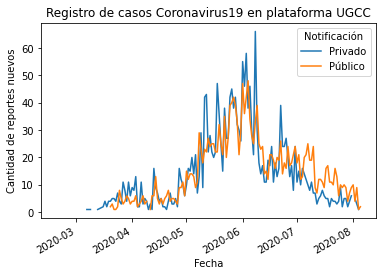

In [14]:
exec(open('./Informe v1/script/02 grafo incidencia casos plataforma.py').read())

Creo un identificador único, ya que el RUT no me sirve (pq hay gente con pasaporte sin RUT, y solo el nombre no me sirve)

In [15]:
BD["ID_personal"] = BD["FECHA NACIMIENTO"].astype(str) + BD["NOMBRES"]


In [16]:
exec(open('./Informe v1/script/03 txt casos duplicados.py').read())

En la base de datos hay 4214 casos, pero hay personas que tienen más de un registro dado que más de un profesional notificó el caso. Existen 3767 personas en los registros y   447 casos que son un segundo, tercer o cuarto registro de un mismo paciente. 
En los registros hay 315 casos activos, de ellos hay 315 personas y 0 casos duplicados de estas personas.


In [17]:
exec(open('./Informe v1/script/04 tab casos publicos y privados por region.py').read())

BD.groupby(['REGION PACIENTE', 'TIPO ESTABLECIMIENTO', 'ESTADO CASO']).ID_personal.count()


ESTADO CASO            Caso activo         Caso histórico        
TIPO ESTABLECIMIENTO       Privado Público        Privado Público
REGION PRESTADOR                                                 
Tarapacá                         0       0              0       4
Antofagasta                      0       0              7      12
Atacama                          0       0              1       1
Coquimbo                         0       2              0       3
Valparaíso                      76     217           1830    1761
Metropolitana                   11       4            130      51
O'Higgins                        0       1              0       4
Maule                            0       1              0       2
Bio Bio                          0       2             15       9
Los Lagos                        1       0              0       2
Magallanes y Antártida           0       0              0       6


REGION PACIENTE         TIPO ESTABLECIMIENTO  ESTADO CASO   
Arica y Parinacota      Privado               Caso activo       0
                                              Caso histórico    0
                        Público               Caso activo       0
                                              Caso histórico    4
Tarapacá                Privado               Caso activo       0
                                                               ..
Aysén                   Público               Caso histórico    0
Magallanes y Antártida  Privado               Caso activo       0
                                              Caso histórico    1
                        Público               Caso activo       0
                                              Caso histórico    1
Name: ID_personal, Length: 64, dtype: int64

In [18]:
BD.loc[BD['SSALUD COMUNA PACIENTE'] == 'SSVMQ'
      ].groupby(['ESTADO CASO']).ID_personal.count()

BD.loc[BD['SSALUD COMUNA PACIENTE'] != 'SSVMQ'
      ].groupby(['ESTADO CASO']).ID_personal.count()


BD.loc[BD['SSALUD COMUNA PACIENTE'] == 'SSVMQ']

BD.groupby(['SSALUD COMUNA PACIENTE', 'TIPO ESTABLECIMIENTO', 'ESTADO CASO']).ID_personal.count()

ESTADO CASO
Caso activo        281
Caso histórico    3294
Name: ID_personal, dtype: int64

ESTADO CASO
Caso activo        34
Caso histórico    605
Name: ID_personal, dtype: int64

,ID CASO,ESTADO CASO,SSALUD COMUNA PACIENTE,TIPO ESTABLECIMIENTO,ESTABLECIMIENTO,CESFAM,TIPO DE ATENCION,TIPO DE HOSPITALIZACION,PACIENTE EXTRANJERO,PAIS ORIGEN,...,VMNI FECHA 2DA CONEXION,VMNI FECHA 2DA DESCONEXION,VMNI FECHA 3RA CONEXION,VMNI FECHA 3RA DESCONEXION,SERVICIOSALUD PRESTADOR,REGION PRESTADOR,TIPO IDENTIFICACION,IDENTIFICACION,PREVISION,ID_personal
0,498,Caso histórico,SSVMQ,Privado,Hospital Naval (Viña del Mar),NaN,HOSPITALARIA,ESTABLECIMIENTO,No,NaN,...,NaT,NaT,NaT,NaT,SSVMQ,Valparaíso,RUN,88784146,ISAPRE,1961-06-17PATRICIO ORLANDO
1,597,Caso histórico,SSVMQ,Público,H. Grant Benavente,NaN,AMBULATORIA,NaN,No,NaN,...,NaT,NaT,NaT,NaT,SSCONCEP,Bio Bio,RUN,190484866,FONASA,1995-10-12VALERIA BELÉN
2,623,Caso histórico,SSVMQ,Privado,Clínica Ciudad del Mar,NaN,HOSPITALARIA,ESTABLECIMIENTO,No,NaN,...,NaT,NaT,NaT,NaT,SSVMQ,Valparaíso,RUN,56035125,ISAPRE,1946-10-20Edgard
3,707,Caso histórico,SSVMQ,Privado,Clínica Ciudad del Mar,NaN,HOSPITALARIA,ESTABLECIMIENTO,No,NaN,...,NaT,NaT,NaT,NaT,SSVMQ,Valparaíso,RUN,5405923K,ISAPRE,1945-12-07IVÁN LUIS PATRICIO
5,763,Caso histórico,SSVMQ,Privado,Clínica Ciudad del Mar,NaN,AMBULATORIA,NaN,Si,Francia,...,NaT,NaT,NaT,NaT,SSVMQ,Valparaíso,PASAPORTE,12CY89647,NaN,1984-08-06ANDRES FELIPE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4210,146399,Caso activo,SSVMQ,Público,H. Gustavo Fricke,NaN,HOSPITALARIA,DOMICILIO,No,NaN,...,NaT,NaT,NaT,NaT,SSVMQ,Valparaíso,RUN,178576062,FONASA,1991-08-17NADIA MÓNICA
4211,146401,Caso activo,SSVMQ,Público,H. Gustavo Fricke,NaN,HOSPITALARIA,DOMICILIO,No,NaN,...,NaT,NaT,NaT,NaT,SSVMQ,Valparaíso,RUN,163029014,ISAPRE,1986-11-03ÍTALO EXEQUIEL
4212,146402,Caso activo,SSVMQ,Público,H. Gustavo Fricke,NaN,HOSPITALARIA,DOMICILIO,No,NaN,...,NaT,NaT,NaT,NaT,SSVMQ,Valparaíso,RUN,183006037,ISAPRE,1993-05-12MAITE TRINIDAD
4213,146406,Caso activo,SSVMQ,Público,H. Gustavo Fricke,NaN,HOSPITALARIA,DOMICILIO,No,NaN,...,NaT,NaT,NaT,NaT,SSVMQ,Valparaíso,RUN,131876394,FONASA,1977-02-02YANINA ANDREA


SSALUD COMUNA PACIENTE  TIPO ESTABLECIMIENTO  ESTADO CASO   
SSACON                  Privado               Caso histórico       9
                        Público               Caso activo          2
                                              Caso histórico      10
SSANORTE                Público               Caso histórico       2
SSANT                   Privado               Caso histórico       6
                        Público               Caso activo          1
                                              Caso histórico       7
SSARICA                 Público               Caso histórico       4
SSASUR                  Público               Caso histórico       2
SSATA                   Privado               Caso histórico       2
SSBIOBIO                Privado               Caso histórico       1
SSCONCEP                Privado               Caso activo          1
                                              Caso histórico       4
                        Público           

In [19]:
exec(open('./Informe v1/script/05 TAB prevision vs prestador.py').read())

TIPO ESTABLECIMIENTO  Privado  Público  Total
ES FONASA                                    
NO                       1034      170   1204
SI                       1009     1910   2919
Total                    2043     2080   4123
TIPO ESTABLECIMIENTO  Privado  Público  Total
ES FONASA                                    
NO                         42        6     48
SI                         46      219    265
Total                      88      225    313
TIPO ESTABLECIMIENTO  Privado  Público  Total
ES FONASA                                    
NO                         33        5     38
SI                         43      210    253
Total                      76      215    291
TIPO ESTABLECIMIENTO  Privado  Público  Total
ES FONASA                                    
NO                          8        1      9
SI                          3        3      6
Total                      11        4     15


Grafico incidencia casos nuevos

In [20]:
len(BD['RUN'])
len(BD['RUN'].unique())
len(BD['RUN']) - len(BD['RUN'].unique())

duplicados = BD.groupby(['RUN'])['ID CASO'].count()
duplicados.value_counts()
duplicados[duplicados>1].describe()

4214

3750

464

1    3366
2     337
3      37
4       4
7       2
5       2
8       1
Name: ID CASO, dtype: int64

count    383.000000
mean       2.174935
std        0.616695
min        2.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        8.000000
Name: ID CASO, dtype: float64

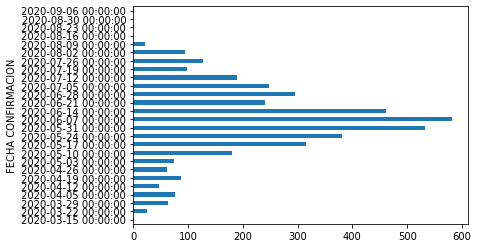

In [21]:
BD.groupby(pd.Grouper(
    key='FECHA CONFIRMACION', 
    freq='w'))['ID CASO'].count().plot(kind='barh')

In [22]:
BD.loc[BD['ES FONASA'] == 'SI', 'Prevision'] = 'Fonasa'
BD.loc[BD['ES FONASA'] == 'NO', 'Prevision'] = 'Isapre'
BD.loc[BD['ES FONASA'].isna()== True, 'Prevision'] = 'Otra'
BD.Prevision.value_counts()

Fonasa    2919
Isapre    1204
Otra        91
Name: Prevision, dtype: int64

(array([  7.,  23.,  33.,  18.,  32.,  30.,  45.,  28.,  63., 120., 157.,
        192., 305., 251., 411., 190., 160., 171., 169., 113., 124.,  61.,
         83.,  65.,  54.,  12.,   0.,   1.,   0.,   1.]),
 array([737503. , 737508.5, 737514. , 737519.5, 737525. , 737530.5,
        737536. , 737541.5, 737547. , 737552.5, 737558. , 737563.5,
        737569. , 737574.5, 737580. , 737585.5, 737591. , 737596.5,
        737602. , 737607.5, 737613. , 737618.5, 737624. , 737629.5,
        737635. , 737640.5, 737646. , 737651.5, 737657. , 737662.5,
        737668. ]),
 <a list of 30 Patch objects>)

(array([  4.,  16.,  30.,  21.,  19.,  25.,  17.,  23.,  22.,  60.,  77.,
        100., 122., 114., 140., 118.,  30.,  62.,  54.,  44.,  40.,   9.,
         21.,  19.,  11.,   5.,   0.,   0.,   0.,   1.]),
 array([737499.        , 737504.63333333, 737510.26666667, 737515.9       ,
        737521.53333333, 737527.16666667, 737532.8       , 737538.43333333,
        737544.06666667, 737549.7       , 737555.33333333, 737560.96666667,
        737566.6       , 737572.23333333, 737577.86666667, 737583.5       ,
        737589.13333333, 737594.76666667, 737600.4       , 737606.03333333,
        737611.66666667, 737617.3       , 737622.93333333, 737628.56666667,
        737634.2       , 737639.83333333, 737645.46666667, 737651.1       ,
        737656.73333333, 737662.36666667, 737668.        ]),
 <a list of 30 Patch objects>)

(array([ 8.,  3., 12., 10.,  2.,  3.,  0.,  0.,  0.,  0.,  2.,  4.,  6.,
         7.,  3.,  3.,  3.,  3.,  5.,  2.,  4.,  2.,  1.,  0.,  3.,  0.,
         1.,  1.,  1.,  2.]),
 array([737501. , 737505.6, 737510.2, 737514.8, 737519.4, 737524. ,
        737528.6, 737533.2, 737537.8, 737542.4, 737547. , 737551.6,
        737556.2, 737560.8, 737565.4, 737570. , 737574.6, 737579.2,
        737583.8, 737588.4, 737593. , 737597.6, 737602.2, 737606.8,
        737611.4, 737616. , 737620.6, 737625.2, 737629.8, 737634.4,
        737639. ]),
 <a list of 30 Patch objects>)

Text(0.5, 1.0, 'Test COVID + en el tiempo')

Text(0, 0.5, 'Cantidad de Casos diarios')

Text(0.5, 0, 'Fecha')

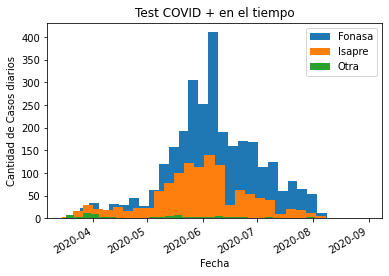

In [23]:
#date = BD['FECHA CONFIRMACION'].astype('O')

dateF = BD.loc[BD.Prevision == 'Fonasa']['FECHA CONFIRMACION'].astype('O')
dateI = BD.loc[BD.Prevision == 'Isapre']['FECHA CONFIRMACION'].astype('O')
dateO = BD.loc[BD.Prevision == 'Otra']['FECHA CONFIRMACION'].astype('O')

fig, ax = plt.subplots()

ax.hist(dateF, bins=30)
ax.hist(dateI, bins=30)
ax.hist(dateO, bins=30)

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m')
ax.set_title('Test COVID + en el tiempo')
ax.set_ylabel('Cantidad de Casos diarios')
ax.set_xlabel('Fecha')
plt.legend(["Fonasa", "Isapre", "Otra"])

# Descripicón del paciente

In [24]:
BD.groupby(
    ['Prevision', BD['FECHA CONFIRMACION'].dt.date])['ID CASO'].plot(x='FECHA CONFIRMACION', y='ID CASO', ax=ax, legend=False)

ValueError: view limit minimum -36882.35 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [ ]:
columnas_paciente = list(
    ['SSALUD COMUNA PACIENTE', 'TIPO ESTABLECIMIENTO', 'ESTABLECIMIENTO',
     'CESFAM', 'TIPO DE ATENCION', 'TIPO DE HOSPITALIZACION',
     'PACIENTE EXTRANJERO', 'PAIS ORIGEN', 'REGION PACIENTE', 'COMUNA',
     'PASAPORTE', 'RUN', 'DV', 'ES FONASA', 'PREVISION', 'SEXO', 'NOMBRES',
     'APELLIDO PATERNO', 'APELLIDO MATERNO', 'FECHA NACIMIENTO',
     'EDAD', 'ANTECEDENTES MORBIDOS'])

In [ ]:
BD[columnas_paciente]